In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
sqlite_path = f"../content_scraper_0.1.0.sqlite3"
engine = create_engine(
    f"sqlite:///{sqlite_path}",
    connect_args={"check_same_thread": False},
)
def get_session():
    """Returns a new session object the current engine

    :return: sqlalchemy Session
    :rtype: session

    """
    Session = sessionmaker(bind=engine)
    return Session()

In [2]:
import content_scraper.db as db
import content_scraper.db.models as models
import preprocessor as p
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import numpy as np

In [3]:
show = True

In [4]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION)

In [5]:
session = get_session()
tweets = [
    p.clean(_.content)
    for _ in session.query(models.TextContent)
    .distinct(models.TextContent.content)
    .group_by(models.TextContent.content)
    .all()
]
session.close()

In [6]:
df = pd.DataFrame({"tweets": tweets})
tweet_lengths = df.tweets.apply(lambda x: len(x.split(" ")))
df["tweet_lengths"] = tweet_lengths

In [7]:
df.head()

,tweets,tweet_lengths
0,"""... charges, but the real story is much more ...",33
1,"""When the adoptive judge is a Democrat darling...",39
2,#BLM #BlackLivesMatter #Racist #rapist #pedoph...,41
3,#Netflix #LeavingNeverland And for anyone sayi...,19
4,# / child porn,4


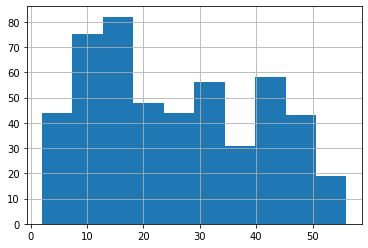

In [8]:
df.tweet_lengths.hist()

In [9]:
df = df[df.tweet_lengths >= 20].copy()

In [10]:
model = SentenceTransformer("bert-base-nli-stsb-mean-tokens")

In [11]:
df['tweet_vecs'] = model.encode(df.tweets.tolist()).tolist()

In [12]:
df

,tweets,tweet_lengths,tweet_vecs
0,"""... charges, but the real story is much more ...",33,"[-0.004512271378189325, -0.21609972417354584, ..."
1,"""When the adoptive judge is a Democrat darling...",39,"[-0.32540997862815857, 0.15205970406532288, 0...."
2,#BLM #BlackLivesMatter #Racist #rapist #pedoph...,41,"[-0.2022828757762909, 0.29071810841560364, -0...."
6,(there's a part in the Fanon chapter where I w...,51,"[0.07333583384752274, -0.37120914459228516, -0..."
7,. #Democrat Judge &amp; Drag Queen-Arrested Fo...,25,"[0.14228159189224243, 0.13649624586105347, 0.8..."
...,...,...,...
486,"tw // mention of cp , mention of child porn (?...",24,"[0.030356334522366524, 0.11425517499446869, 0...."
488,why is it ALWAYS the people who draw child por...,23,"[0.38921982049942017, -0.3868502676486969, 0.3..."
496,You must be over 18 to see the porn weve drawn...,47,"[0.21359507739543915, -0.25989052653312683, 0...."
498,"$1,483,552 $BTC #LONGED $52,216 [25/03/21 04:4...",24,"[0.2695656418800354, 0.07488363236188889, -0.3..."


In [13]:
def cos_distance(a, b):
    a_dot_b = np.dot(a,b)
    mag_a_mag_b = np.linalg.norm(a) * np.linalg.norm(b)
    return (a_dot_b / mag_a_mag_b)

def calc_distances(df_x, target_row):
  print(f'Looking for texts close to [{df_x.tweets.iloc[target_row]}]')
  body_vecs = df_x.body_vec.tolist()
  distances = list()
  for i in range(0, len(body_vecs)):
    dist = cos_distance(tweet_vecs[i], tweet_vecs[target_row])
    distances.append(dist)

  df_x['distances'] = distances
  df_x.distances.hist()
  return(df_x)

In [14]:
search_string = df.tweets.iloc[0]
similarity_threshold = 0.5
rows = 50

vectorized_input = model.encode([search_string])[0]

def find_similar_strings(df_a, query_vec, threshold=similarity_threshold, target_column='tweet_vecs'):
  body_vecs = df_a[target_column].tolist()
  distances = []
  for i in range(0, len(body_vecs)):
    dist = cos_distance(body_vecs[i], query_vec)
    distances.append(dist)

  df_a['similarity'] = distances
  df_a = df_a.sort_values(by=['similarity'], ascending=False)
  df_a = df_a[df_a['similarity'] > threshold]
  return (df_a)

df_closest_matches = find_similar_strings(df.copy(), vectorized_input, similarity_threshold)
df_closest_matches[['tweets', 'similarity']].head(n=rows)

,tweets,similarity
0,"""... charges, but the real story is much more ...",1.000000
268,A disturbing collection of child porn -- both ...,0.670026
11,"// cp , sexualization of minors bruh imagine h...",0.649365
365,Like if Shadman drew shit with just fictional ...,0.629695
415,Tell you what I don't like next door in the ph...,0.607103
136,"They draw gore, child porn, obsess over dream ...",0.599452
431,Thread: You may have seen the bizarre headline...,0.592708
6,(there's a part in the Fanon chapter where I w...,0.591247
191,Apparently shes got loads of links to child po...,0.587916
135,Imagine how the federal agents who have to sur...,0.584750


In [15]:
if False:
   df_closest_matches[['tweets', 'similarity']].to_csv("query_results.csv")

## Topics

In [16]:
from sklearn.cluster import KMeans

all_body_vecs = np.asarray(df.tweet_vecs.tolist())
kmeans = KMeans(n_clusters=20, random_state=0).fit(all_body_vecs)

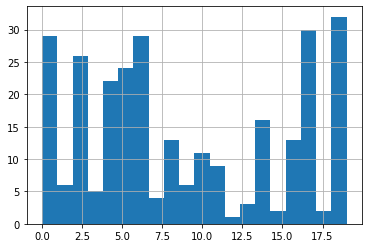

In [18]:
cluster_labels = kmeans.predict(all_body_vecs)
df['label'] = cluster_labels
df.label.hist(bins=20)

In [37]:
label = 0

In [38]:
df[df.label==label].shape

(29, 4)

In [39]:
from IPython.display import display
display(df[df.label==label][['tweets']].head(n=20).style.set_properties(**{
        'width': '1000px',
        'max-width': '1000px'
    }))

,tweets
17,"It clearly states that ""SIYA'S FORMER COACH"" and not Siya himself so why make a mountain out of an ant hill. Siya is not bothered with this his not implicated in any child porn scandal his former coach is and I bet blacks will say his brainwashed by whites"
19,Following my first Lefty homeschooler. Thats cool. Hope youll get after that adoption agency that allowed two men indulging in child porn to adopt two children. How did Brett Blomme happen? What were they doing to their adopted children?
22,"Owning child porn is a federal crime and he would have been charged with it. People pull info out their arse to defend 2 middle-aged men that suddenly did a 180 after facing financial ruin, who have even taken to harassing families because no one will join their cash grab"
37,He literally left a comment on Omnis video admitting it to having child porn in his server for years lol
70,"Im sorry, but youre a bit late to the party. That fiction child porn film has been thoroughly debunked as fraudulent two years ago. The men accusing him are proven perjurers and liars with no credibility left. Theyre done, thrown out of the court system too. No money for them."
72,are you also angry about Oprah who after visiting MJ's ranch in 1993 for her hit interview KNEW there was NO TRAIN STATION BUILT during the alleged abuse but still gave her stamp of approval to this child porn movie?
91,Hunter Biden also has a lot of explaining to do regarding that child porn video of him snorting cocaine off an 11 year old sex slave's naked backside.
101,And the government even gave permission for people to start a political party full of pedos but the leader got arrested with 2tb of child porn that was found in his house
125,Ur speaking utter nonsense. If u were a Siya Kolisi would you accept your name being attached to this shit when u didnt have any child porn in your possession? When u arent even in Australia? Niyayitweeta ikaka yaz
143,what you are definitely late for is that this child porn movie has been debunked 2 years ago and contains 60 + lies. none of the 2 crooks have brought one piece of evidence in the movie nor in court where they've been thrown out from multiple times.
